In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import random
import numpy as np
from scipy.spatial import distance_matrix

In [2]:
os.chdir('R:\TechM\-Support-Vector-Machine-Implementation-on-D-Wave-Quantum-Annealer-main\-Support-Vector-Machine-Implementation-on-D-Wave-Quantum-Annealer-main')

In [3]:
random.seed(34)

In [4]:
df = pd.read_csv('data/1056lab-credit-card-fraud-detection/train.csv')
df = df.drop(['ID', 'Time'],axis=1)
df = df.sample(frac=1)

In [5]:
df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

In [6]:
df0 = df0.iloc[0:700,:]
df1 = df1.iloc[0:300,:]

In [7]:
df_new = df0.append(df1)
df_new = df_new.sample(frac=1)

In [8]:
df_new['Class'].value_counts()

0    700
1    300
Name: Class, dtype: int64

In [9]:
df_new['Class'].value_counts(1)

0    0.7
1    0.3
Name: Class, dtype: float64

In [10]:
encoder = LabelEncoder()

# Now apply the transformation to all the columns:
for col in df_new.columns:
    df_new[col] = encoder.fit_transform(df_new[col])
X_features = df_new.iloc[:,0:29]
y_label = df_new.iloc[:,29:30]

In [11]:
# Scale the features
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

In [12]:
# Visualize
pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_
pca2 = PCA(n_components=4)
pca2.fit(X_features)
x_3d = pca2.transform(X_features)


In [13]:
x_3d

array([[-1.73137565, -2.12554341,  0.0586721 ,  0.87777902],
       [ 5.04165244, -1.73325613,  0.36754291,  1.93020191],
       [ 5.83853491, -0.4155247 ,  0.31821416, -1.10996772],
       ...,
       [-2.3445875 ,  0.48688472,  0.33329514, -0.11526489],
       [-1.72747433, -0.0608376 , -0.48712811,  0.82856532],
       [-2.38585526, -1.55455134,  0.09984331,  1.82609707]])

In [14]:
training_data = np.append(x_3d, y_label, axis=1)

In [15]:
training_data.shape

(1000, 5)

In [16]:
label = training_data[:,4]

In [17]:
import neal
import math
from dwave.system import LeapHybridSampler
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler
import time

In [18]:
TYPE = 'SA'

# Select the solver
if(TYPE == 'HQPU'):
    sampler = LeapHybridSampler()
if(TYPE == 'SA'):
    sampler = neal.SimulatedAnnealingSampler()
if(TYPE == 'QPU'):
    sampler = EmbeddingComposite(DWaveSampler())


N = 950
validation_pts = 50
xi = 0.001


def kernel(x, y, gamma):
    if gamma == -1:
        k = np.dot(x, y)
    elif gamma >= 0:
        k = np.exp(-gamma*(np.linalg.norm(x-y, ord=2)))
    return k

def delta(i, j):
    if i == j:
        return 1
    else:
        return 0

def predict_class(x_test, alpha, b):
    N = len(alpha)
    f = sum([alpha[n]*t[n]*kernel(data[n], x_test, gamma)
                for n in range(N)]) + b
    return f

def train_SVM(x, K, t):

    Q_tilde = np.zeros((K*N, K*N))
    for n in range(N):
        for m in range(N):
            for k in range(K):
                for j in range(K):
                    Q_tilde[(K*n+k, K*m+j)] = 0.5*(B**(k+j))*t[n]*t[m] * \
                        (kernel(x[n], x[m], gamma)+xi) - \
                        (delta(n, m)*delta(k, j)*(B**k))

    Q = np.zeros((K*N, K*N))
    for j in range(K*N):
        Q[(j, j)] = Q_tilde[(j, j)]
        for i in range(K*N):
            if i < j:
                Q[(i, j)] = Q_tilde[(i, j)] + Q_tilde[(j, i)]

    size_of_q = Q.shape[0]
    qubo = {(i, j): Q[i, j]
            for i, j in product(range(size_of_q), range(size_of_q))}

    now = time.time()
    if(TYPE == 'HQPU'):
        response = sampler.sample_qubo(qubo)
    if(TYPE == 'SA'):
        response = sampler.sample_qubo(qubo, num_reads=100)
    if(TYPE == 'QPU'):
        response = sampler.sample_qubo(qubo, num_reads=100)

    print((time.time() - now)/60)

    a = response.first.sample
    print(response.first.energy)

    alpha = {}
    for n in range(N):
        alpha[n] = sum([(B**k)*a[K*n+k] for k in range(K)])

    b = sum([alpha[n]*(C-alpha[n])*(t[n]-(sum([alpha[m]*t[m]*kernel(x[m], x[n], gamma)
                                                for m in range(N)]))) for n in range(N)])/sum([alpha[n]*(C-alpha[n]) for n in range(N)])

    return alpha, b



In [19]:
# ----- Predict class of a data point -----

# ----- Set up parameters -----
B = 2  # base used for encoding the real variables
K = 2  # number of binary variables used for encoding
C = 3  # regularization parameter

# constraint penalty
gamma = 16  # kernel hyperparameter



for i in range(N+validation_pts):
    if(training_data[i][-1] == 0):
        training_data[i][-1] = -1

data = training_data[:N+validation_pts, :2]
t = training_data[:N + validation_pts, -1]

x_min, x_max = 1000, 0
y_min, y_max = 1000, 0
# rescalling data
for i in range(N+validation_pts):
    x_min = min(data[i][0], x_min)
    x_max = max(data[i][0], x_max)
    y_min = min(data[i][1], y_min)
    y_max = max(data[i][1], y_max)

for i in range(N+validation_pts):
    data[i][0] = (data[i][0] - x_min)/(x_max - x_min)
    data[i][1] = (data[i][1] - y_min)/(y_max - y_min)




In [20]:
alpha, b = train_SVM(data, K, t)

0.781008243560791
-208.9008073359728


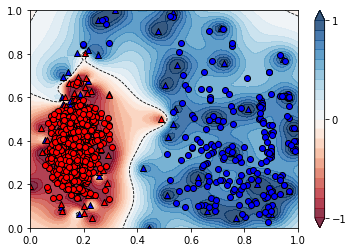

In [21]:
# Plot results:
plot_fig = 1

if plot_fig:
    plt.figure()
    cm = plt.cm.RdBu

    xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 80),
                            np.linspace(0.0, 1.0, 80))
    Z = []
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx[row])):
            target = np.array([xx[row][col], yy[row][col]])
            Z_row.append(predict_class(target, alpha, b))
        Z.append(Z_row)

    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1,
                                                    0.1), cmap=cm, alpha=0.8, extend="both")

    plt.contour(xx, yy, Z, levels=[0.0], colors=(
        "black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    red_sv = []
    blue_sv = []
    red_pts = []
    blue_pts = []

    for i in range(N):
        if(alpha[i]):
            if(t[i] == 1):
                blue_sv.append(data[i, :2])
            else:
                red_sv.append(data[i, :2])

        else:
            if(t[i] == 1):
                blue_pts.append(data[i, :2])
            else:
                red_pts.append(data[i, :2])

    plt.scatter([el[0] for el in blue_sv],
                [el[1] for el in blue_sv], color='b', marker='^', edgecolors='k', label="Type 1 SV")

    plt.scatter([el[0] for el in red_sv],
                [el[1] for el in red_sv], color='r', marker='^', edgecolors='k', label="Type -1 SV")

    plt.scatter([el[0] for el in blue_pts],
                [el[1] for el in blue_pts], color='b', marker='o', edgecolors='k', label="Type 1 Train")

    plt.scatter([el[0] for el in red_pts],
                [el[1] for el in red_pts], color='r', marker='o', edgecolors='k', label="Type -1 Train")

In [22]:
tp, fp, tn, fn = 0, 0, 0, 0
for i in range(N, N+validation_pts):
    cls = predict_class(data[i], alpha, b)
    y_i = t[i]
    if(y_i == 1):
        if(cls > 0):
           
            tp += 1
        else:

            fp += 1
    else:
        if(cls < 0):

            tn += 1
        else:
            fn += 1

# calculate KPI's

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = tp/(tp + 1/2*(fp+fn))
accuracy = (tp + tn)/(tp+tn+fp+fn)

print("f1_score = {} accuracy = {} precision = {} recall = {}".format(f_score, accuracy,precision,recall))





f1_score = 0.967741935483871 accuracy = 0.98 precision = 0.9375 recall = 1.0
